In [1]:
import msprime
import numpy as np
from IPython.display import SVG
%load_ext rpy2.ipython
# %reload_ext rpy2.ipython

# A state space model for mutations along two genomes

## State space model: Simonsen-Churchill framework

This is the full transition rate matrix:

In [2]:
%%R

ARGRateM_slow <- function(rho){
  RateM <-
    matrix(c(0,rho,0,0,0,0,0,1,
             1,0,rho/2,1,1,0,0,0,             
             0,4,0,0,0,1,1,0,
             0,0,0,0,0,rho/2,0,1,
             0,0,0,0,0,0,rho/2,1,
             0,0,0,2,0,0,0,1,
             0,0,0,0,2,0,0,1,
             0,0,0,0,0,0,0,0),nrow=8,ncol=8,byrow=TRUE)
  ## Get diagonals right (must sum to 0)
  for (rw in 1:8){
    RateM[rw,rw] <- -sum(RateM[rw,])
  }
  return(RateM)
}

ARGRateMat_slow <- ARGRateM_slow(0.1*2)

ARGRateMat_slow

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,] -1.2  0.2  0.0  0.0  0.0  0.0  0.0    1
[2,]  1.0 -3.1  0.1  1.0  1.0  0.0  0.0    0
[3,]  0.0  4.0 -6.0  0.0  0.0  1.0  1.0    0
[4,]  0.0  0.0  0.0 -1.1  0.0  0.1  0.0    1
[5,]  0.0  0.0  0.0  0.0 -1.1  0.0  0.1    1
[6,]  0.0  0.0  0.0  2.0  0.0 -3.0  0.0    1
[7,]  0.0  0.0  0.0  0.0  2.0  0.0 -3.0    1
[8,]  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0


This is the fast version of the function above, where some of the states are removed from the chain if we are only interested in the heights:

In [3]:
%%R

ARGRateM <- function(rho){
  RateM <-
    matrix(
        c(-(1+rho),        rho,     0, 1,
                 1, -(3+rho/2), rho/2, 2,
                 0,          4,    -6, 2, 
                 0,          0,     0, 0),
        nrow=4,ncol=4,byrow=TRUE)
}

ARGRateMat <- ARGRateM(0.1*2)

ARGRateMat

     [,1] [,2] [,3] [,4]
[1,] -1.2  0.2  0.0    1
[2,]  1.0 -3.1  0.1    2
[3,]  0.0  4.0 -6.0    2
[4,]  0.0  0.0  0.0    0


Equation (1) and figure 2A can be coded this way:

In [4]:
%%R


library("tidyverse")
library('expm')
library('reshape2')
library('patchwork')

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘expm’


R[write to console]: The following object is masked from ‘package:Matrix’:

    expm


R[write to console]: 
Attaching package: ‘reshape2’


R[write to console]: The following object is masked from ‘package:tidyr’:

    smiths




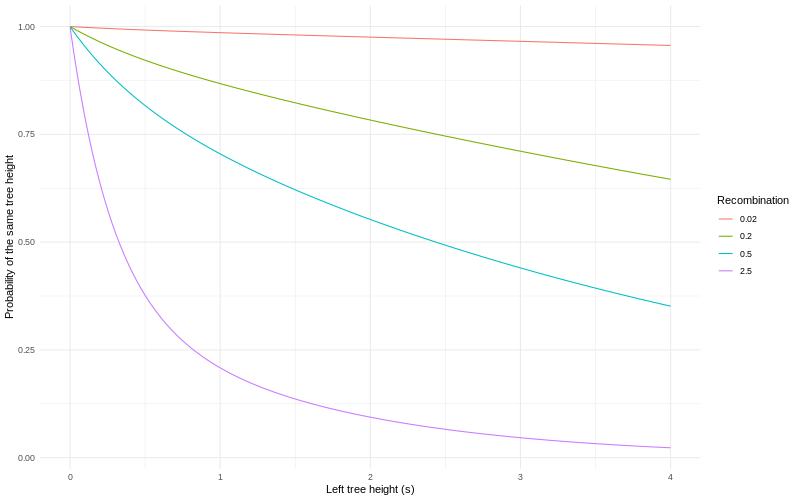

In [5]:
%%R -w 800 -h 500



n <- 1000
s <- seq(from=0.001, to=4.0,length=n)

# Table with the values
tab_dat <- expand.grid(
        s_tib = s, 
        rho_tib = c(0.02, 0.2, 0.5, 2.5)) %>%
    # For each row
    rowwise() %>%
    # Get the probablity by applying eq. (1)
    mutate(
        den = (exp(s_tib)*expm(ARGRateM(rho_tib)*s_tib)[1,1])) %>%
    ungroup() %>%
    mutate(
        Recombination = as.character(rho_tib)
    )
    
    
tab_dat %>% 
    ggplot() + 
    geom_line(aes(s_tib, den, color = Recombination)) +
    theme_minimal() +
    ylab('Probability of the same tree height') +
    xlab('Left tree height (s)')
    

The following code is for reproducing figure 2B from equation (2):

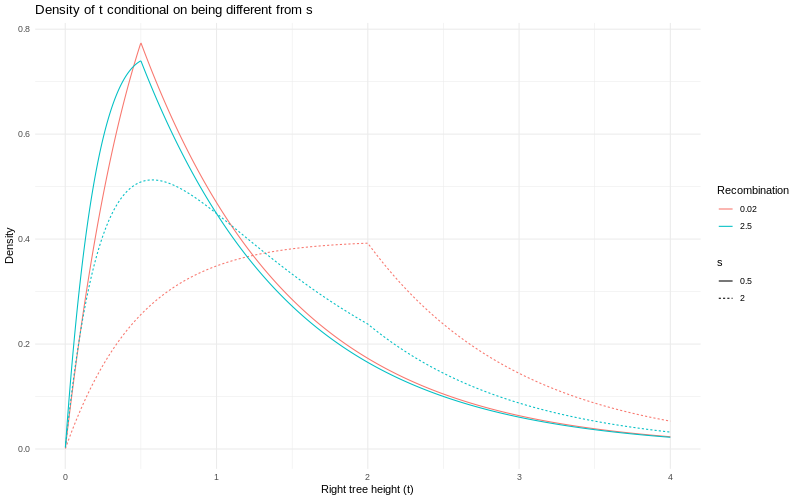

In [6]:
%%R -w 800 -h 500

# This function is the variable part
# within equation (2), this is, the 
# numerator
ARGTrns <- function(rho, s, t){
    ARGRateMat <- ARGRateM(rho)
    expm.s <- expm(ARGRateMat*s)
    exp(-(t-s))*(expm.s[1,2]+expm.s[1,3])
    
}

# Define the data frame with array of t
# and different values of rho and base s
n <- 1000
t <- seq(from=0.001, to=4.0,length=n)  
tab_dat <- expand.grid(
        t_tib = t, 
        rho_tib = c(0.02, 2.5), 
        s_tib = c(0.5, 2)) %>% 
    # For each row
    rowwise() %>%
    mutate(
        # Calculate numerator
        den = 
            ifelse(
                t_tib > s_tib, 
                ARGTrns(rho_tib, s_tib, t_tib),
                ARGTrns(rho_tib, t_tib, s_tib)),
        # Divide by denominator
        den = 
            den/(exp(-s_tib)-expm(ARGRateM(rho_tib)*s_tib)[1,1])) %>%
    ungroup() %>%
    mutate(
        Recombination = as.character(rho_tib),
        s = as.character(s_tib)
    )
    
tab_dat %>% 
    ggplot() + 
    geom_line(aes(t_tib, den, color = Recombination, linetype = s)) +
    theme_minimal() +
    ylab('Density') +
    xlab('Right tree height (t)') +
    ggtitle('Density of t conditional on being different from s')



## Time discretization: setting up the finite state HMM

In [7]:
%%R

FastTransMat <- function(tm,rho){
  # This produces a rate matrix which has an additional state,
  # number 4, which represents states 4, 5, 6 and 7 of the 
  # 'slow' matrix. Thus, state 5 corresponds to the absorbing
  # state, i.e. state 8 in the 'slow' matrix. 
  rate_mat <- matrix(c(-(1+rho),rho,0,0,1,
                              1,-(3+rho/2),rho/2,2,0,             
                              0,4,-6,2,0,
                              0,0,0,-1,1,
                              0,0,0,0,0),
                            nrow=5,ncol=5,byrow=TRUE)
  nInt <- length(tm) ## Number of intervals
  tm0 <- c(0,tm) ## tm0 is tm with time 0 added
  ##-------------------------------------
  JointMat <- matrix(0,nrow=nInt,ncol=nInt) ## Joint prb matrix
  for (j in 1:(nInt-1)){  ## Left state
    for (k in j:nInt){  ## Right state
      if (j<k){
        JointMat[j,k] <-
          expm(tm0[j]*rate_mat)[1,1:3]%*%
          expm((tm[j]-tm0[j])*rate_mat)[1:3,4]*
          exp(-(tm0[k]-tm[j]))*
          # which is the same as 
          # expm((tm0[k]-tm[j])*rate_mat)[4,4]*0.5*
            (1-exp(-(tm[k]-tm0[k])))*0.5
            # which is the same as 
            # expm((tm[k]-tm0[k])*rate_mat)[4,5]
            # but because expm can't handle infinity, 
            # we need to do a workaround 
        # Symmetrize
        JointMat[k,j] <- JointMat[j,k]
      }
      if (j==k){
        JointMat[j,k] <-
          expm(tm0[j]*rate_mat)[1,1:3]%*%
          expm((tm[j]-tm0[j])*rate_mat)[1:3,5]
      }
    }
  }
  ## Final entry
  JointMat[nInt,nInt] <- sum(expm(tm0[nInt]*rate_mat)[1,1:3])
  ## Again: expm can't handle infinity, and state 8 is absorbing
  ## Transition matrix 
  TransMat <- JointMat/rowSums(JointMat)
  return(TransMat)
}


In [8]:
%%R -o rho


calc_tm <- function(nInt) -log(1-1:(nInt)/nInt)

nInt <- 10
tm <- calc_tm(nInt)
rho <- 0.01*2
TransM <- FastTransMat(tm, rho)

print(tm)
print(diag(TransM))
print(length(tm))
length(diag(TransM))

 [1] 0.1053605 0.2231436 0.3566749 0.5108256 0.6931472 0.9162907 1.2039728
 [8] 1.6094379 2.3025851       Inf
 [1] 0.9990682 0.9972782 0.9954836 0.9936588 0.9917681 0.9897602 0.9875591
 [8] 0.9850538 0.9821519 0.9821519
[1] 10
[1] 10


# Simulation of the ancestral history

We can now simulate the ancestral history of 2 haploid samples under the coalescent with recombination using msprime.

In [9]:
rho = float(rho)

ts = msprime.sim_ancestry(
    samples=2,
    recombination_rate=rho/2,
    sequence_length=100_000,
    random_seed = 237244,
    population_size = 1,
    ploidy = 1
)
# Visualise the simulated ancestral history.
# SVG(ts.draw_svg())

We can now calculate the number of sites belonging to each tree inferred by msprime, together with the number of transitions between the trees: 

In [10]:
# Create a matrix with 0 values
trans_mat = np.zeros((ts.num_nodes-2, ts.num_nodes-2))
first = True
# For each tree
for tree in ts.trees():
    # If not the first iteration
    if not first:
        # Count transition
        trans_mat[n_prev, tree.root-2] += 1
    # Update previous iteration counter
    n_prev = tree.root-2
    first = False
    # Add number of sites in that tree to diagonal
    trans_mat[tree.root-2, tree.root-2] += tree.span-1

In [11]:
trans_mat[1:10, 1:10]

array([[4.691e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 4.934e+03, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 6.290e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 8.190e+02, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.040e+02, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.766e+03,
        0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.010e+02, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.760e+02, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00

We can also recover the height  each tree in the simulation:

In [12]:
tree_heights = ts.tables.nodes[2:].asdict()['time'].tolist()
tree_heights[1:10]

[0.013873747738190756,
 0.017326989920286775,
 0.03329138727791482,
 0.04148320396516912,
 0.04839498751758654,
 0.048761773373448565,
 0.049384745665559976,
 0.05083948911968467,
 0.055629973694139356]

We now have all the ingredients to simplify the simulated transition matrix based on the cutpoints defined by the discretized times:

In [119]:
%%R -i trans_mat -i tree_heights

# Import the tre heights as vector
tree_heights <- unlist(tree_heights)

# Create vector for assigning each simulated tree to an interval
cut_vec <- cut(tree_heights, breaks = c(0,tm), labels = FALSE, right = FALSE)

# Create empty matrix with the right dimensions
discrete_mat <- matrix(0, length(tm), length(tm))

# For each interval
for (i in 1:length(tm)) {
    # Save indices of trees belonging to interval i
    vec_idx_i <- which(cut_vec == i)
        # For each interval
        for (j in 1:length(tm)) {
            # Save indices of trees belonging to interval j
            vec_idx_j <- which(cut_vec == j)
            # If both indices are non-empty
            if ((length(vec_idx_i) != 0) & (length(vec_idx_j) != 0)) {
                # Save sum of the sub-matrix
                discrete_mat[i, j] <- 
                    sum(trans_mat[vec_idx_i, vec_idx_j])   
        }
    }
}


discrete_mat

       [,1] [,2] [,3] [,4]  [,5] [,6]  [,7] [,8] [,9] [,10]
 [1,] 18174    1    1    2     1    1     2    3    1     1
 [2,]     1 4797    1    0     7    1     2    1    3     2
 [3,]     1    1 6705    6     4    5     6    5    7     3
 [4,]     3    2    6 6480     9    9     8    6    7     6
 [5,]     1    3    5   11 12069   20    17   13   14    14
 [6,]     2    3    5    6    13 8723    26   22   15    14
 [7,]     2    3    3   10    18   23 12583   22   25    26
 [8,]     0    1    5    6    16   16    21 9616   43    37
 [9,]     1    3    8   10    15   16    24   32 9710    78
[10,]     1    1    4    5    15   15    26   41   72 10169


We know that, in theory, the transition matrix should be symmetric. This is approximately true looking at the empirical matrix. We can force it to be symmetric:

In [120]:
%%R

for (i in 1:length(tm)) {
    for (j in i:length(tm)) {
        me <- mean(c(discrete_mat[i, j], discrete_mat[j, i]))
        discrete_mat[i, j] = me
        discrete_mat[j, i] = me
    }
}

discrete_mat

         [,1]   [,2]   [,3]   [,4]    [,5]   [,6]    [,7]   [,8]   [,9]   [,10]
 [1,] 18174.0    1.0    1.0    2.5     1.0    1.5     2.0    1.5    1.0     1.0
 [2,]     1.0 4797.0    1.0    1.0     5.0    2.0     2.5    1.0    3.0     1.5
 [3,]     1.0    1.0 6705.0    6.0     4.5    5.0     4.5    5.0    7.5     3.5
 [4,]     2.5    1.0    6.0 6480.0    10.0    7.5     9.0    6.0    8.5     5.5
 [5,]     1.0    5.0    4.5   10.0 12069.0   16.5    17.5   14.5   14.5    14.5
 [6,]     1.5    2.0    5.0    7.5    16.5 8723.0    24.5   19.0   15.5    14.5
 [7,]     2.0    2.5    4.5    9.0    17.5   24.5 12583.0   21.5   24.5    26.0
 [8,]     1.5    1.0    5.0    6.0    14.5   19.0    21.5 9616.0   37.5    39.0
 [9,]     1.0    3.0    7.5    8.5    14.5   15.5    24.5   37.5 9710.0    75.0
[10,]     1.0    1.5    3.5    5.5    14.5   14.5    26.0   39.0   75.0 10169.0


In order to get the probabilities, we can divide each row by the total counts per row. In theory, this should be the same as dividing it by the total number per column, but in the simulations there might be some differences due to the matrix not being completely symmetric. In order to avoid this and forcing the matrix to be symmetric, we can divide in both ways and then get the mean of the two:

In [126]:
%%R

# Divide by the row sums
discrete_mat_1 <- discrete_mat/rowSums(discrete_mat)
# Divide by the col sums
discrete_mat_2 <- t(t(discrete_mat) / colSums(discrete_mat))
# Get the mean of the two
my.list <- list(discrete_mat_1, discrete_mat_2)

discrete_mat <- Reduce("+", my.list) / length(my.list)

# Check that  rowSums and colSums are equal and roughly 1
print(rowSums(discrete_mat))
print(colSums(discrete_mat))

discrete_mat

 [1] 1 1 1 1 1 1 1 1 1 1
 [1] 1 1 1 1 1 1 1 1 1 1
              [,1]         [,2]         [,3]         [,4]         [,5]
 [1,] 9.989068e-01 0.0001313742 0.0001016629 0.0002601207 0.0000685250
 [2,] 1.313742e-04 0.9972596254 0.0001781518 0.0001805656 0.0007245324
 [3,] 1.016629e-04 0.0001781518 0.9951408129 0.0009049252 0.0005184396
 [4,] 2.601207e-04 0.0001805656 0.0009049252 0.9929023505 0.0011759776
 [5,] 6.852500e-05 0.0007245324 0.0005184396 0.0011759776 0.9905351974
 [6,] 1.262064e-04 0.0003212234 0.0006544027 0.0009995809 0.0016119170
 [7,] 1.334819e-04 0.0003577615 0.0005103611 0.0010422126 0.0014050154
 [8,] 1.180612e-04 0.0001551565 0.0006271710 0.0007669714 0.0013377813
 [9,] 7.799439e-05 0.0004633014 0.0009353634 0.0010804262 0.0013274231
[10,] 7.577498e-05 0.0002283025 0.0004287065 0.0006868416 0.0012952290
              [,6]         [,7]         [,8]         [,9]        [,10]
 [1,] 0.0001262064 0.0001334819 0.0001180612 7.799439e-05 7.577498e-05
 [2,] 0.0003212234 0.000357

We can start comparing the theoretical and the simulated matrices. First, we can compare the diagonal values. 

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



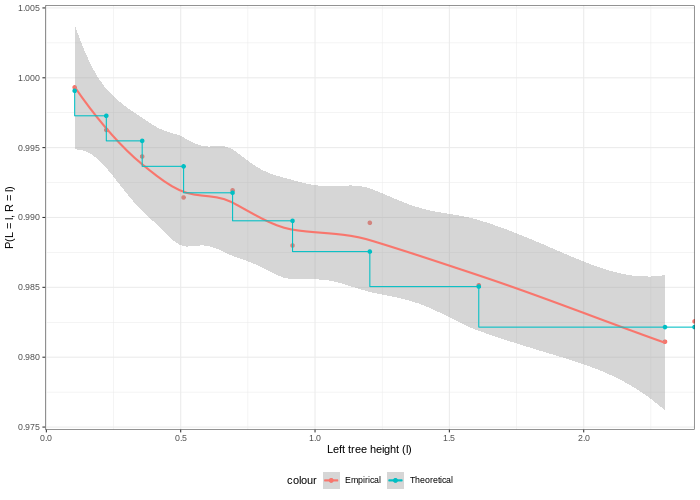

In [122]:
%%R  -w 700 -h 500

ggplot() +
    geom_point(aes(tm, diag(discrete_mat), color = 'Empirical')) +
    geom_smooth(aes(tm, diag(discrete_mat), color = 'Empirical')) +
    geom_point(aes(tm, diag(TransM), color = 'Theoretical')) +
    geom_step(aes(tm, diag(TransM), color = 'Theoretical'), direction="vh") +
    theme_bw() +
    theme(legend.position = 'bottom') +
    ylab(paste0('P(L = l, R = l)')) +
    xlab(paste0('Left tree height (l)'))
    


Note that the x values for the points are the upper boundaries in tree height of each of the intervals. 

We can also compute the probability given a certain interval. For example, we can plot the probabilities for when the left tree height is in the interval number 10:

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



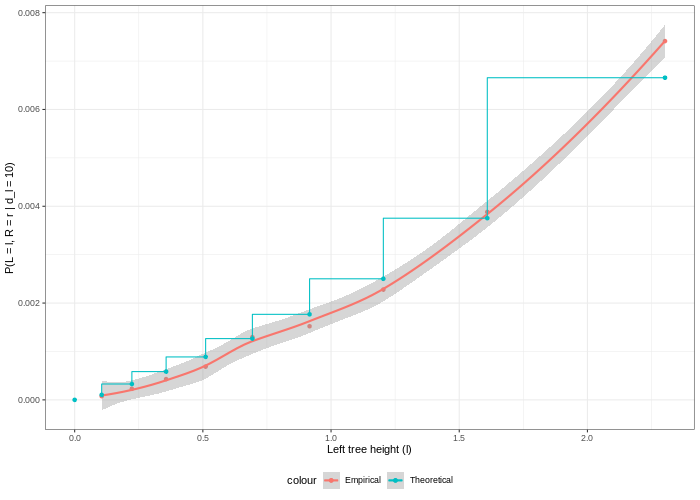

In [123]:
%%R  -w 700 -h 500

interval <- 10

ggplot() +
    geom_point(aes(tm[-interval], discrete_mat[interval,][-interval], color = 'Empirical')) +
    geom_smooth(aes(tm[-interval], discrete_mat[interval,][-interval], color = 'Empirical')) +
    geom_step(aes(tm[-interval], TransM[interval,][-interval], color = 'Theoretical'), direction="vh") +
    geom_point(aes(c(0, tm[-interval]), c(0, TransM[interval,][-interval]), color = 'Theoretical')) +
    theme_bw() +
    theme(legend.position = 'bottom') +
    ylab(paste0('P(L = l, R = r | d_l = ', interval, ')')) +
    xlab(paste0('Left tree height (l)'))
    


Note that the x values for the points are the upper boundaries in tree height of each of the intervals. Also, the y value corresponding to the analyzed interval is also removed for simplicity. 

We can also compare the matrices as a whole by plotting them side by side. The color scale is log-transformed to be able to see the values off the diagonal. Also, those values in the simulated matrix with a probability of 0 (because they were not found) are defaulted to the lowest color in the scale:

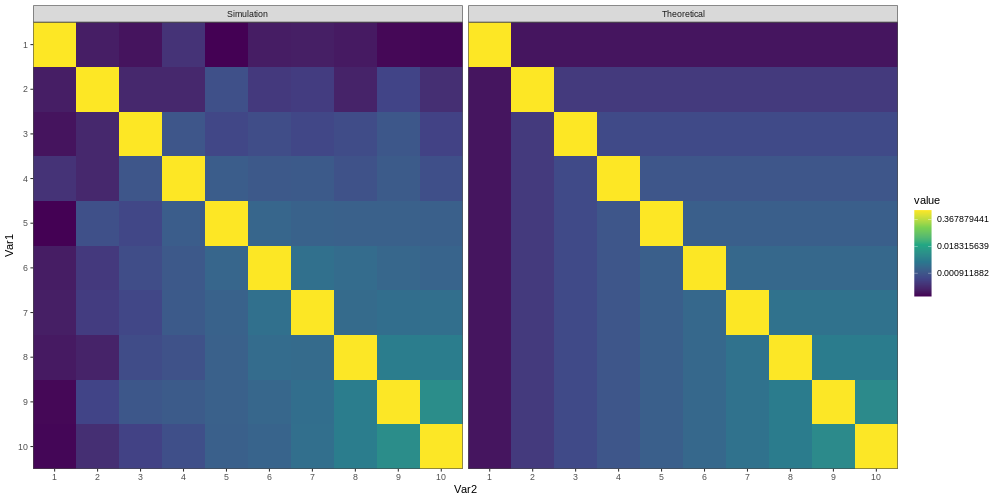

In [124]:
%%R  -w 1000 -h 500

melt(discrete_mat) %>% 
    mutate(type = 'Simulation') %>%
    bind_rows(
        mutate(
            melt(TransM),
            type = 'Theoretical'
        )
    ) %>%
    ggplot() +
    geom_tile(aes(Var2, Var1, fill = value)) +
    scale_y_reverse(breaks = 1:nInt, expand = c(0, 0)) +
    scale_x_continuous(breaks = 1:nInt, expand = c(0, 0)) +
    facet_wrap(~type) +
    theme_bw() +
    scale_fill_viridis_c(
        trans = 'log', 
        na.value = hcl.colors(1)
    )



# The mutational process

After proving that the simulated values for the transition matrix match the theoretical expectation, we can now move on to analyzing the mutational process. We can calculate the probability for a mutation in a given discretized interval using the following:

In [49]:
%%R -o tht

calc_p_mut <- function(tm, tht) {
    tm_1 <- c(0, tm[1:(length(tm)-1)])
    prob_mutation <- rep(NA, length(tm))
    for (i in 1:length(tm)){
        prob_mutation[i] <- 1-exp(-tht*tm_1[i])*(1-exp(-(1+tht)*(tm[i]-tm_1[i])))/(1-exp(-(tm[i]-tm_1[i])))/(1+tht)
    }
    prob_mutation
}

tht = 0.005*2

prob_mut <- calc_p_mut(tm, tht = tht)

prob_mut

 [1] 0.0005173735 0.0016295753 0.0028800086 0.0043083023 0.0059741237
 [6] 0.0079735639 0.0104768334 0.0138331765 0.0189785487 0.0324383951


We are now ready to simulate the mutational process on top of the tree collection previously simulated using msprime:

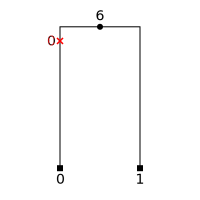

In [50]:
tht = float(tht)

mutated_ts = msprime.sim_mutations(
    ts,
    rate = tht/2,
    model = 'infinite_alleles',
    random_seed = 12901
)

SVG(mutated_ts.first().draw_svg())

We can now recover the number of mutations that happened in each of the trees:

In [51]:
# Create a matrix with 0 values
mut_mat = np.zeros((mutated_ts.num_nodes-2, 2))
first = True
# For each tree
for tree in mutated_ts.trees():
    # Save the number of positions in the tree
    mut_mat[tree.root-2, 0] += tree.span
    # save the number of mutations
    mut_mat[tree.root-2, 1] += tree.num_mutations
    
mut_mat

array([[4.640e+02, 0.000e+00],
       [4.692e+03, 0.000e+00],
       [4.935e+03, 2.000e+00],
       ...,
       [7.000e+00, 0.000e+00],
       [2.000e+01, 1.000e+00],
       [1.200e+01, 1.000e+00]])

We can now calculate the number of mutations for each of the discretized intervals:

In [52]:
%%R -i mut_mat

(mutat_tib <- as_tibble(mut_mat) %>%
    # add the interval associated to each tree
    mutate(
        bin = cut_vec
    ) %>%
    # group by each interval
    group_by(bin) %>%
    # calculate the number of sites 
    # and mutations per interval
    summarize(
        sites = sum(V1),
        mutations = sum(V2),
        p_obs = mutations/sites
    ) %>%
    # add the expected probability and height
    mutate(
        p_exp = prob_mut,
        height = tm[bin]
    ))

# A tibble: 10 × 6
     bin sites mutations    p_obs    p_exp  height
   <int> <dbl>     <dbl>    <dbl>    <dbl>   <dbl>
 1     1 18187         6 0.000330 0.000517   0.105
 2     2  4815        11 0.00228  0.00163    0.223
 3     3  6743        17 0.00252  0.00288    0.357
 4     4  6536        26 0.00398  0.00431    0.511
 5     5 12167        77 0.00633  0.00597    0.693
 6     6  8829        72 0.00815  0.00797    0.916
 7     7 12715       137 0.0108   0.0105     1.20 
 8     8  9761       134 0.0137   0.0138     1.61 
 9     9  9897       165 0.0167   0.0190     2.30 
10    10 10350       337 0.0326   0.0324   Inf    


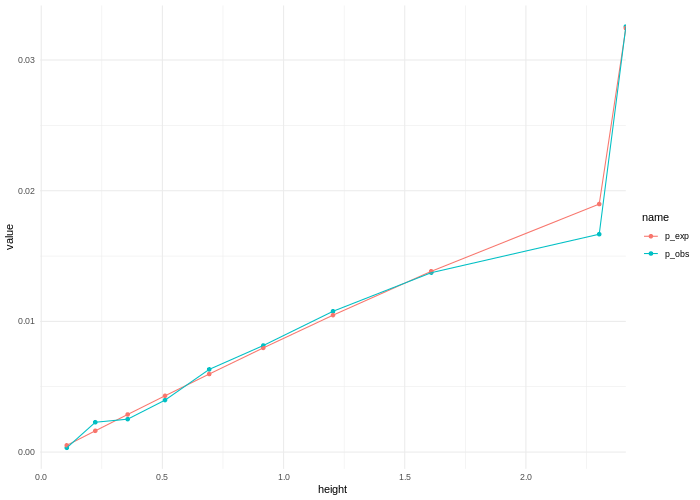

In [53]:
%%R -w 700 -h 500

mutat_tib %>%    
    pivot_longer(starts_with("p_")) %>%
    ggplot() +
        geom_point(aes(height, value, color = name)) +
        geom_line(aes(height, value, color = name)) +
        theme_minimal()

# Hidden Markov model

We can think of the ancestral history with recombination and mutation as a hidden Markov model (HMM), where the discretized tree heights are the hidden states and the mutations are the emitted observations. We now have all the ingredients for building a hidden Markov model:

* The initial probabilities.
* The transition probability matrix will be the transition matrix for the discretized times, which is dependant on rho.
* The emission probability matrix will be the probability of observing (or not) a mutation, which is dependant on both rho and theta.

The following code can be used to calculate the logarithmic forward likelihood given the initial probabilities, the transition probabilities, the emission probabilities and a vector of the observed mutations. The function is thus the forward algorithm for a HMM, and it returns a matrix with the log-transformed likelihoods:

In [54]:
%%R

logFrwdLikFct <- function(InitProb,TransProb,EmisProb,ObsSeq){
  # Number of observations
  len <- length(ObsSeq)
  # Number of hidden states
  nHS <- nrow(TransProb)
  # Define logForwardLik
  logForwardLik <- matrix(0,nrow=len,ncol=nHS)
  # Start condition
  logForwardLik[1,] <- log(InitProb*EmisProb[,ObsSeq[1]])
  # Determine logForwardLik by recursion 
  for(k in 2:len){
    a <- max(logForwardLik[k-1,])
    # Calculate the loglik of current iteration
    logForwardLik[k,] <- 
      log(colSums(
          (exp(logForwardLik[k-1,]-a)%*%TransProb)*EmisProb[,ObsSeq[k]]
      ))+a
  }  
  # a <- max(logForwardLik[len,])
  # logForwardLikVal <- log(sum(EndProb*exp(logForwardLik[len,]-a)))+a
  return(logForwardLik)
}

The above code has a little trick to improve numerical stability. For each iteration, it substracts the maximum loglik value of the previous iteration to the loglik values of the previous iteration before exponentiating them. After performing all the computations, we go back to the logarithm and we will add the value we substracted earlier.

Additionally, we can also code the backward algorithm for a HMM:

In [55]:
%%R

logBkwdLikFct <- function(TransProb,EmisProb,ObsSeq){
  # Number of observations
  len <- length(ObsSeq)
  # Number of hidden states
  nHS <- nrow(TransProb)
  # Define logBackwardLik
  logBackwardLik <- matrix(0,nrow=len,ncol=nHS)
  # Determine logForwardLik by recursion 
  for(k in (len-1):1){
    a <- max(logBackwardLik[k+1,])
    # Calculate the loglik of current iteration
    logBackwardLik[k,] <- 
      log(colSums(
          (exp(logBackwardLik[k+1,]-a)%*%TransProb)*EmisProb[,ObsSeq[k]]
      ))+a
  }  
  return(logBackwardLik)
}

In order to run the forward-backward algorithm, we should calculate the observed mutations first:

In [56]:
mut_pos = []
for variant in mutated_ts.variants():
    mut_pos.append(int(variant.position))
mut_pos[1:10]

[877, 957, 961, 1024, 1038, 1154, 1312, 1413, 1502]

We can create a binary vector, where a 1 means that there is a mutation in that position, and a 0 indicates a lack of mutation. This will be our vector of observations:

In [57]:
mut_pos_bin = np.zeros(int(mutated_ts.sequence_length), dtype=np.int32)
for i in range(int(mutated_ts.sequence_length)):
    if i in mut_pos:
        mut_pos_bin[i] = 1
    else:
        mut_pos_bin[i] = 0
mut_pos_bin[1:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [58]:
%%R -i mut_pos_bin


initial <- rep(1/nInt, nInt)
transition <- FastTransMat(tm, rho)
emission <- matrix(c(1-calc_p_mut(tm, tht),calc_p_mut(tm, tht)),ncol=2,byrow=FALSE)
mat_forward<- logFrwdLikFct(initial, transition, emission, mut_pos_bin+1)

mat_forward[1:5,1:10]

          [,1]      [,2]      [,3]      [,4]      [,5]      [,6]      [,7]
[1,] -2.303103 -2.304216 -2.305469 -2.306903 -2.308577 -2.310591 -2.313117
[2,] -2.303630 -2.305874 -2.308396 -2.311275 -2.314632 -2.318663 -2.323711
[3,] -2.304167 -2.307559 -2.311364 -2.315701 -2.320749 -2.326799 -2.334362
[4,] -2.304713 -2.309271 -2.314373 -2.320179 -2.326925 -2.334996 -2.345070
[5,] -2.305268 -2.311007 -2.317422 -2.324707 -2.333159 -2.343254 -2.355830
          [,8]      [,9]     [,10]
[1,] -2.316515 -2.321746 -2.335561
[2,] -2.330485 -2.340890 -2.368179
[3,] -2.344493 -2.360012 -2.400438
[4,] -2.358536 -2.379110 -2.432338
[5,] -2.372609 -2.398179 -2.463879


In [59]:
%%R

transition <- FastTransMat(tm, rho)
emission <- matrix(c(1-calc_p_mut(tm, tht),calc_p_mut(tm, tht)),ncol=2,byrow=FALSE)
mat_backward <- logBkwdLikFct(transition, emission, mut_pos_bin+1)

mat_backward[1:5,1:10]

          [,1]      [,2]      [,3]      [,4]      [,5]      [,6]      [,7]
[1,] -5312.420 -5312.294 -5312.943 -5313.524 -5313.919 -5314.193 -5314.408
[2,] -5312.419 -5312.290 -5312.938 -5313.518 -5313.913 -5314.187 -5314.403
[3,] -5312.418 -5312.286 -5312.932 -5313.511 -5313.907 -5314.182 -5314.397
[4,] -5312.417 -5312.283 -5312.927 -5313.505 -5313.901 -5314.176 -5314.392
[5,] -5312.416 -5312.279 -5312.921 -5313.499 -5313.895 -5314.170 -5314.386
          [,8]      [,9]     [,10]
[1,] -5314.602 -5314.806 -5315.120
[2,] -5314.597 -5314.800 -5315.115
[3,] -5314.591 -5314.795 -5315.109
[4,] -5314.585 -5314.789 -5315.104
[5,] -5314.580 -5314.784 -5315.098


In [60]:
%%R

max_df <- apply(mat_forward+mat_backward, 1, which.max)

max_df[1:100]

  [1] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2


## HMM optimization over rho

Let's now run the forward algorithm over a grid of rho values and save the loglik associated to them. In order to do so, we have to specify a fixed value of theta:

In [128]:
%%R -i mut_pos_bin



rho.v <- seq(from=rho-(rho/2), to=rho+(rho/2), length.out = 20)
logL_rho.v <- rep(0,len=length(rho.v))

for (i in 1:length(rho.v)) {
    initial <- rep(1/nInt, nInt)
    transition <- FastTransMat(tm, rho.v[i])
    emission <- matrix(c(1-calc_p_mut(tm, tht),calc_p_mut(tm, tht)),ncol=2,byrow=FALSE)
    logForwardMat <- logFrwdLikFct(initial, transition, emission, mut_pos_bin+1)
    a <- max(logForwardMat[nrow(logForwardMat),])
    logL_rho.v[i] <- log(sum(exp(logForwardMat[nrow(logForwardMat),]-a)))+a
    print(paste0("rho=",round(rho.v[i], 4),", log likelihood=",logL_rho.v[i]))
}



[1] "rho=0.01, log likelihood=-5317.06869494841"
[1] "rho=0.0111, log likelihood=-5316.08091517552"
[1] "rho=0.0121, log likelihood=-5315.29581327172"
[1] "rho=0.0132, log likelihood=-5314.68070899756"
[1] "rho=0.0142, log likelihood=-5314.20930726601"
[1] "rho=0.0153, log likelihood=-5313.86018849949"
[1] "rho=0.0163, log likelihood=-5313.61573101842"
[1] "rho=0.0174, log likelihood=-5313.46131968845"
[1] "rho=0.0184, log likelihood=-5313.38475068558"
[1] "rho=0.0195, log likelihood=-5313.37577464308"
[1] "rho=0.0205, log likelihood=-5313.42574002909"
[1] "rho=0.0216, log likelihood=-5313.52731082226"
[1] "rho=0.0226, log likelihood=-5313.6742403942"
[1] "rho=0.0237, log likelihood=-5313.86118867291"
[1] "rho=0.0247, log likelihood=-5314.08357314407"
[1] "rho=0.0258, log likelihood=-5314.33744665351"
[1] "rho=0.0268, log likelihood=-5314.6193966713"
[1] "rho=0.0279, log likelihood=-5314.92646189421"
[1] "rho=0.0289, log likelihood=-5315.25606296247"
[1] "rho=0.03, log likelihood=-5315

Instead of defining a grid of values ourselves, we can simply use the `optimize` function in R to calculate the value with the largest loglik:

In [62]:
%%R

optim_rho <- function(rho) {
    initial <- rep(1/nInt, nInt)
    transition <- FastTransMat(tm, rho)
    emission <- matrix(c(1-calc_p_mut(tm, tht),calc_p_mut(tm, tht)),ncol=2,byrow=FALSE)
    logForwardMat <- logFrwdLikFct(initial, transition, emission, mut_pos_bin+1)
    a <- max(logForwardMat[nrow(logForwardMat),])
    log(sum(exp(logForwardMat[nrow(logForwardMat),]-a)))+a
    
}

max_lik_rho <- optimize(optim_rho, c(rho-(rho/2), rho+(rho/2)), maximum = TRUE)

max_lik_rho

$maximum
[1] 0.01910313

$objective
[1] -5313.372



When plotting these results together, we can see that the optimization worked quite well:

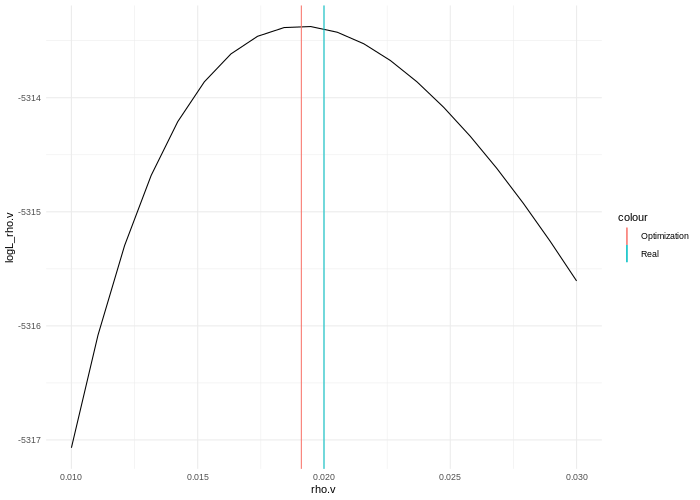

In [63]:
%%R -w 700 -h 500

ggplot() +
    geom_line(aes(rho.v, logL_rho.v)) +
    geom_vline(aes(xintercept = rho, color = 'Real')) +
    geom_vline(aes(xintercept = max_lik_rho$maximum, color = 'Optimization')) +
    theme_minimal()

## HMM optimization over theta

Additionally, we can also optimize for theta by choosing a fixed value for rho:

In [129]:
%%R -i mut_pos_bin

tht.v <- seq(from=tht-(tht/2), to=tht+(tht/2), length.out = 20)
logL_tht.v <- rep(0,len=length(tht.v))

for (i in 1:length(tht.v)) {
    initial <- rep(1/nInt, nInt)
    transition <- FastTransMat(tm, rho)
    emission <- matrix(c(1-calc_p_mut(tm, tht.v[i]),calc_p_mut(tm, tht.v[i])),ncol=2,byrow=FALSE)    
    logForwardMat <- logFrwdLikFct(initial, transition, emission, mut_pos_bin+1)
    a <- max(logForwardMat[nrow(logForwardMat),])
    logL_tht.v[i] <- log(sum(exp(logForwardMat[nrow(logForwardMat),]-a)))+a
    print(paste0("tht=",round(tht.v[i], 4),", log likelihood=",logL_tht.v[i]))
}



[1] "tht=0.005, log likelihood=-5411.67477425374"
[1] "tht=0.0055, log likelihood=-5384.44129649646"
[1] "tht=0.0061, log likelihood=-5363.57077450188"
[1] "tht=0.0066, log likelihood=-5347.70034747019"
[1] "tht=0.0071, log likelihood=-5335.80192047839"
[1] "tht=0.0076, log likelihood=-5327.0853227387"
[1] "tht=0.0082, log likelihood=-5320.93389683466"
[1] "tht=0.0087, log likelihood=-5316.86027739118"
[1] "tht=0.0092, log likelihood=-5314.47519665448"
[1] "tht=0.0097, log likelihood=-5313.46496252009"
[1] "tht=0.0103, log likelihood=-5313.57487070003"
[1] "tht=0.0108, log likelihood=-5314.59677653646"
[1] "tht=0.0113, log likelihood=-5316.35964511979"
[1] "tht=0.0118, log likelihood=-5318.72227381293"
[1] "tht=0.0124, log likelihood=-5321.56762508423"
[1] "tht=0.0129, log likelihood=-5324.79836969141"
[1] "tht=0.0134, log likelihood=-5328.33335056391"
[1] "tht=0.0139, log likelihood=-5332.10475439738"
[1] "tht=0.0145, log likelihood=-5336.05583232855"
[1] "tht=0.015, log likelihood=-5

In [65]:
%%R

optim_tht <- function(tht) {
    initial <- rep(1/nInt, nInt)
    transition <- FastTransMat(tm, rho)
    emission <- matrix(c(1-calc_p_mut(tm, tht),calc_p_mut(tm, tht)),ncol=2,byrow=FALSE)
    logForwardMat <- logFrwdLikFct(initial, transition, emission, mut_pos_bin+1)
    a <- max(logForwardMat[nrow(logForwardMat),])
    log(sum(exp(logForwardMat[nrow(logForwardMat),]-a)))+a
}

max_lik_tht <- optimize(optim_tht, c(tht-(tht/2), tht+(tht/2)), maximum = TRUE)

max_lik_tht

$maximum
[1] 0.009924588

$objective
[1] -5313.387



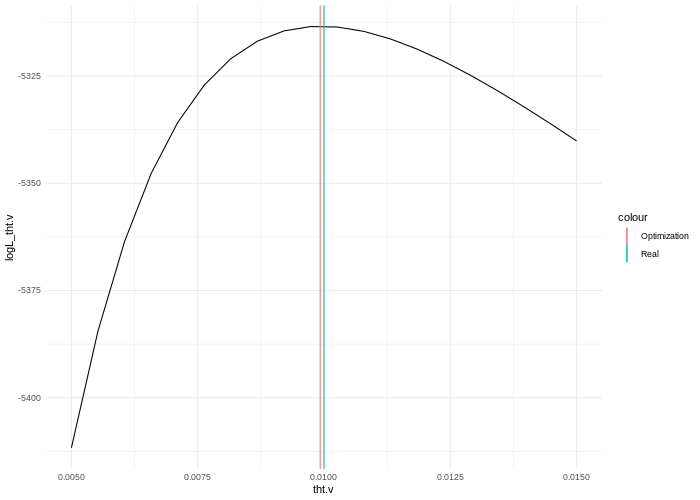

In [66]:
%%R -w 700 -h 500

ggplot() +
    geom_line(aes(tht.v, logL_tht.v)) +
    geom_vline(aes(xintercept = tht, color = 'Real')) +
    geom_vline(aes(xintercept = max_lik_tht$maximum, color = 'Optimization')) +
    theme_minimal()

## HMM optimization over both rho and theta

In [67]:
%%R

library(optimParallel)

fun_optim <- function(x) {
    require(expm)
    rho <- x[1]
    tht <- x[2]
    initial <- rep(1/nInt, nInt)
    transition <- FastTransMat(tm, rho)
    emission <- matrix(c(1-calc_p_mut(tm, tht),calc_p_mut(tm, tht)),ncol=2,byrow=FALSE)
    logForwardMat <- logFrwdLikFct(initial, transition, emission, mut_pos_bin+1)
    a <- max(logForwardMat[nrow(logForwardMat),])
    log(sum(exp(logForwardMat[nrow(logForwardMat),]-a)))+a
}

cl <- makeCluster(20)     # set the number of processor cores
setDefaultCluster(cl=cl)  # set 'cl' as default cluster
clusterExport(cl=cl, c('nInt', 'mut_pos_bin', 'tm', 'FastTransMat', 'calc_p_mut', 'logFrwdLikFct'))
optim_both <- optimParallel(c(rho, tht), 
                            fun_optim, 
                            lower = c(0.001, 0.001),
                            upper = c(1, 1),
                            parallel = list(loginfo = TRUE),
                            control = list(ndeps=1e-4, fnscale = -1, pgtol = 0)
                            )

In [68]:
%%R

optim_both

$par
[1] 0.018598357 0.009861651

$value
[1] -5313.344

$counts
function gradient 
       8        8 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

$loginfo
     step       par1        par2       fn           gr1           gr2
[1,]    1 0.02000000 0.010000000 5313.394  4.774606e+01  2.228542e+02
[2,]    2 0.00100000 0.001000000 5926.792  5.884705e+04 -6.321185e+05
[3,]    3 0.01480736 0.007540327 5324.139  7.182206e+02 -1.175689e+04
[4,]    4 0.01979351 0.009902187 5313.377  5.668334e+01 -9.808485e+01
[5,]    5 0.01968350 0.009892547 5313.372  5.305639e+01 -1.119171e+02
[6,]    6 0.01851692 0.009854476 5313.344 -3.271131e+00 -8.957146e+00
[7,]    7 0.01860441 0.009861964 5313.344  2.889223e-01 -1.298641e-01
[8,]    8 0.01859836 0.009861651 5313.344  5.808943e-04  8.425018e-03



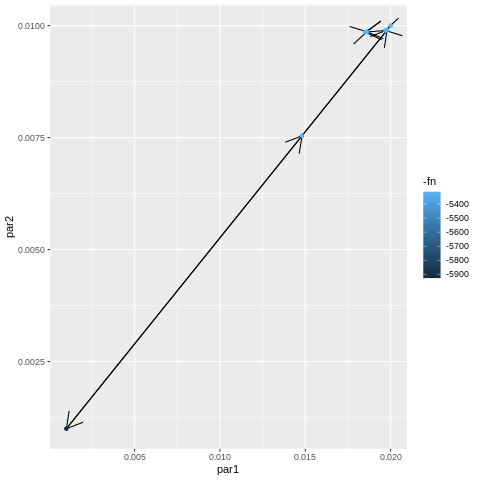

In [69]:
%%R

optim_both$loginfo %>%
    as_tibble() %>%
    mutate(
        par1_end = lead(par1),
        par2_end = lead(par2)) %>%
    ggplot() +
    geom_segment(aes(x = par1, y = par2, xend = par1_end, yend = par2_end), arrow = arrow()) +
    geom_point(aes(par1, par2, color = -fn)) 

## Visualization of the HMM

Now that we have obtained our maximum likelihood estimates for rho and theta, we can try to visualize the posterior state predictions. First, we will retrieve the tree index each position belongs to:

In [70]:
# Create a matrix with 0 values
pos_vec = np.zeros((int(mutated_ts.sequence_length)))

pos = 0
# For each tree
for tree in mutated_ts.trees():
    # Save tree index
    pos_vec[pos:int(pos+tree.span)] = tree.root-2
    pos += int(tree.span)
    

pos_vec[1:10]

array([4., 4., 4., 4., 4., 4., 4., 4., 4.])

We can now run the forward-backward algorithm with the optimized parameters, and get the most probable path:

In [71]:
%%R -i mut_pos_bin

# Save new parameters
rho_max <- optim_both$par[1]
tht_max <- optim_both$par[2]

initial <- rep(1/nInt, nInt)
transition <- FastTransMat(tm, rho_max)
emission <- matrix(c(1-calc_p_mut(tm, tht_max), calc_p_mut(tm, tht_max)), ncol=2,byrow=FALSE)

mat_forward <- logFrwdLikFct(initial, transition, emission, mut_pos_bin+1)
mat_backward <- logBkwdLikFct(transition, emission, mut_pos_bin+1)
max_df <- apply(mat_forward+mat_backward, 1, which.max)

We can now visualize how good our HMM performed:

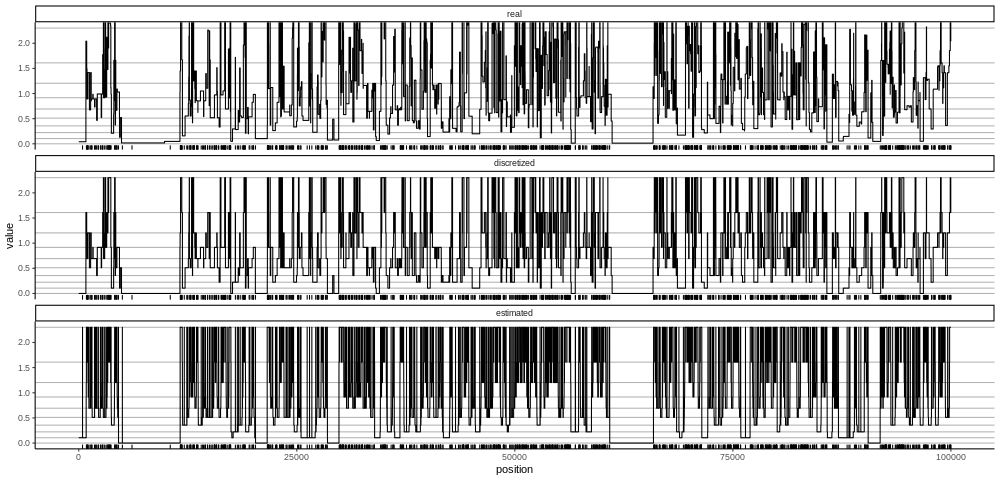

In [83]:
%%R -i pos_vec -i mut_pos_bin -w 1000

a_tab <- tibble(
        # Position along the genome
        position = 1:length(pos_vec),
        # Real tree heights
        real = tree_heights[pos_vec+1],
        # Real discretized tree heights:
        # the minimum tree height per interval is saved
        # as a proxy for the tree height
        discretized = c(0,tm)[cut_vec[pos_vec+1]],
        # Estimated discretized tree heights:
        # the minimum tree height per interval is saved
        # as a proxy for the tree height
        estimated = c(0,tm)[max_df],
        mutation = mut_pos_bin) %>%
    # Get a sample of the sequence
    #slice(10000:20000) %>%
    pivot_longer(-c(position, mutation)) %>%
    mutate(
        name = factor(name, 
                      c('real', 'discretized', 'estimated')
                     )
    )
    
    
rug_tab <- 
    a_tab %>%
    filter(name == 'discretized') %>%
    filter(mutation == 1) %>%
    select(position)

a_tab %>%
    ggplot() +
    geom_hline(aes(yintercept = y),
               alpha = 0.3,
               data = tibble(y = c(0,tm[1:(nInt-1)]))) +
    geom_line(aes(position, value)) +
    geom_rug(aes(x = position), data = rug_tab) +
    #scale_y_continuous(trans = scales::log_trans(),
    #                   breaks = scales::log_breaks()) +
    facet_wrap(~name, ncol = 1) +
    coord_cartesian(ylim=c(0, tm[(nInt-1)])) +
    theme_classic()



`real` corresponds to the real tree heights of the msprime simulated dataset, `discretized` corresponds to the same values as `real` but divided in discrete intervals, and `estimated` corresponds to the discretized tree heights estimated by the forward-backward algorithm. For both `discretized` and `estimated`, the minimum value per interval was used as a proxy for the tree height. The `geom_rug` depicts the mutations along the simulated genome. Note that the y axis has been cropped for clarity (only the largest values of `real` are really affected). 

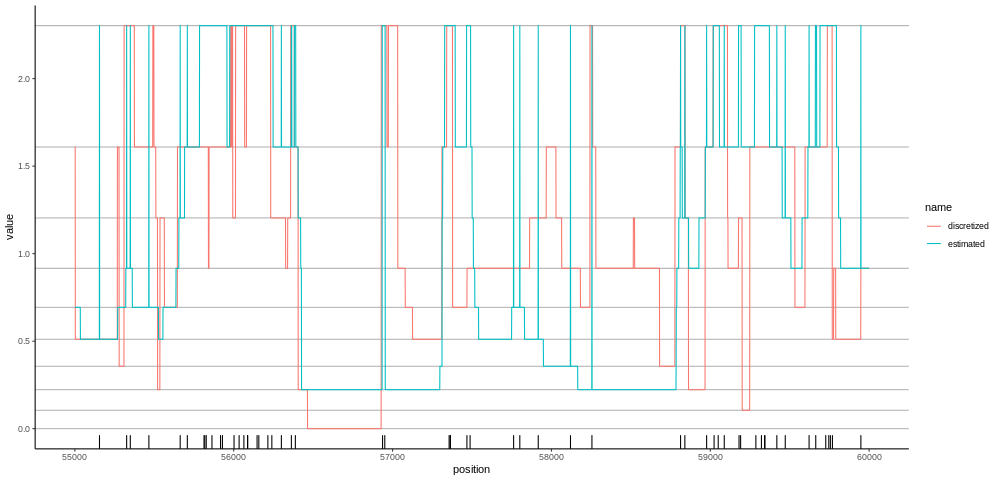

In [81]:
%%R -w 1000

a_tab <- tibble(
        # Position along the genome
        position = 1:length(pos_vec),
        # Real tree heights
        real = tree_heights[pos_vec+1],
        # Real discretized tree heights:
        # the minimum tree height per interval is saved
        # as a proxy for the tree height
        discretized = c(0,tm)[cut_vec[pos_vec+1]],
        # Estimated discretized tree heights:
        # the minimum tree height per interval is saved
        # as a proxy for the tree height
        estimated = c(0,tm)[max_df],
        mutation = mut_pos_bin) %>%
    slice(55000:60000) %>%
    pivot_longer(-c(position, mutation)) %>%
    mutate(
        name = factor(name, 
                      c('real', 'discretized', 'estimated')
                     )
    )
    
    
rug_tab <- 
    a_tab %>%
    filter(name == 'discretized') %>%
    filter(mutation == 1) %>%
    select(position)

a_tab %>%
    filter(name != 'real') %>%
    ggplot() +
    geom_hline(aes(yintercept = y),
               alpha = 0.3,
               data = tibble(y = c(0,tm[1:(nInt-1)]))) +
    geom_line(aes(position, value, color = name)) +
    geom_rug(aes(x = position), data = rug_tab) +
    #scale_y_continuous(trans = scales::log_trans(),
    #                   breaks = scales::log_breaks()) +
    theme_classic()

In [43]:
# !jupyter nbconvert --to script 01_msprime_simulations.ipynb